# Chocolate confectionery

This report briefly addresses forecasting of Monthly production of chocolate confectionery in Australia: tonnes. July 1957 – Aug 1995 (see [here](https://datamarket.com/data/set/22rl/monthly-production-of-chocolate-confectionery-in-australia-tonnes-july-1957-aug-1995#!ds=22rl&display=line)) using Python.

## 1. Data understanding

In [3]:
import warnings
def ignore_warnings(*args, **kwargs):
    pass
warnings.warn = ignore_warnings 

from math import sqrt

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

from pyramid.arima import auto_arima

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

The first step is to load the dataset. In order to read the dataset as time series, a date parser function is defined as follows.  

In [5]:
#Load dataset
df = pd.read_csv("chocolate.csv", index_col = 'Month', parse_dates = ['Month'], 
                 date_parser = lambda x : pd.to_datetime(x, format = '%Y-%m'))

df.index

DatetimeIndex(['1957-07-01', '1957-08-01', '1957-09-01', '1957-10-01',
               '1957-11-01', '1957-12-01', '1958-01-01', '1958-02-01',
               '1958-03-01', '1958-04-01',
               ...
               '1994-11-01', '1994-12-01', '1995-01-01', '1995-02-01',
               '1995-03-01', '1995-04-01', '1995-05-01', '1995-06-01',
               '1995-07-01', '1995-08-01'],
              dtype='datetime64[ns]', name='Month', length=458, freq=None)

Note that the type of the index variable, i.e., Month, is not of object type and converted into datetime. Now that, we have a sneak peek at the chocolate confectionary dataset.

In [29]:
print(df.head())

            Volume
Month             
1957-07-01    2953
1957-08-01    2635
1957-09-01    2404
1957-10-01    2413
1957-11-01    2136


Then, the descriptive summary of the dataset is provided as follows. 

In [30]:
print(df.describe())

             Volume
count    458.000000
mean    5150.641921
std     2202.939593
min     1066.000000
25%     3554.250000
50%     4724.500000
75%     6480.000000
max    11095.000000


## 2. Exploring data

In [6]:
#Set up helper function for data visualization 
def plt_(dataset, title):    
    plt.figure(figsize=(12,6))
    plt.plot(dataset, color = 'b')
    plt.ylabel('Tonnes')
    plt.title(title)
    plt.show()
    
def density_plt_(dataset):
    plt.figure(figsize=(10,5))
    sns.distplot(dataset)
    plt.title('Density plot')
    plt.show()   

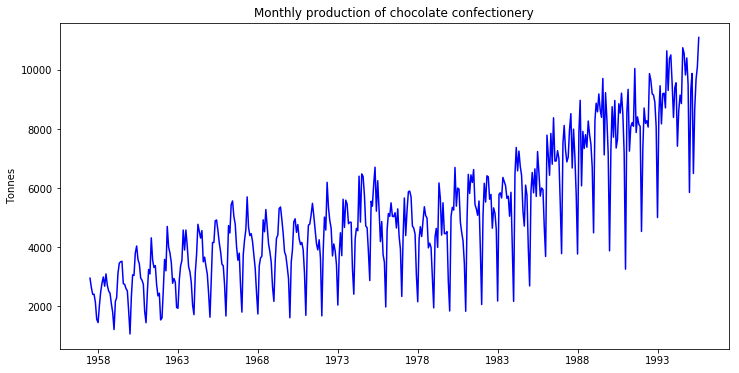

In [32]:
#Time series plot
plt_(df, "Monthly production of chocolate confectionery")

The monthly production plot suggests that there is an increasing trend of sales over time. Further, it illustrates seasonality patterns over time which does not seem to be multiplicative. Another observation is that there is not any obvious outlier in the dataset. Given the exisitng trend and seasonality, the dataset is therefore non-stationary. 

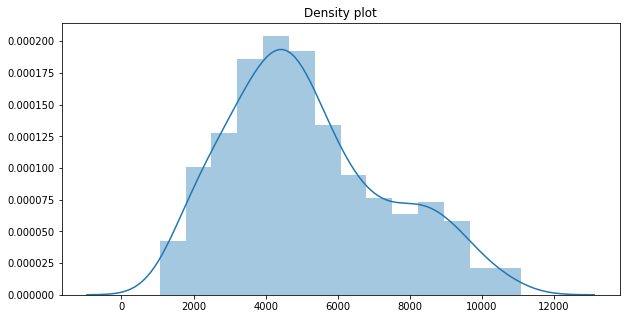

In [7]:
#Density plot
density_plt_(df)

As illustrated by density plot, the observation represents a skewed distribution which can be roughly estimated by normal one. The underlying time series dataset can be decomposed into its componenets that are trend, seasonality, and sesidual as shown below. 

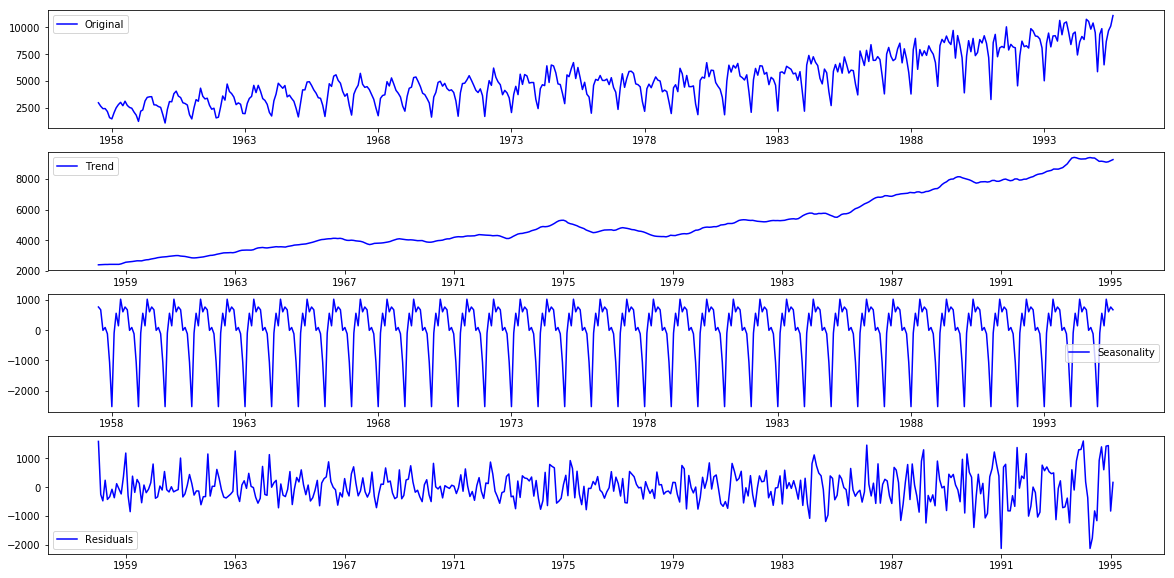

In [39]:
#Decomposition
def _decom(dataset):
      
    decomposition = seasonal_decompose(dataset)

    fig = plt.figure(figsize = (20, 10))
    ax = fig.add_subplot(411)
    ax.plot(dataset, label='Original', color = 'b')
    ax.legend(loc='best')
    ax = fig.add_subplot(412)
    ax.plot(decomposition.trend, label='Trend', color = 'b')
    ax.legend(loc='best')
    ax = fig.add_subplot(413)
    ax.plot(decomposition.seasonal,label='Seasonality', color = 'b')
    ax.legend(loc='best')
    ax= fig.add_subplot(414)
    ax.plot(decomposition.resid, label='Residuals', color = 'b')
    ax.legend(loc='best')
    plt.show()
    
_decom(df[df.columns[0]])

As expected, increasing trend and seasonality signal are present in the dataset. It can further be validated by applying "Dickey-Fuller test" as follows.  

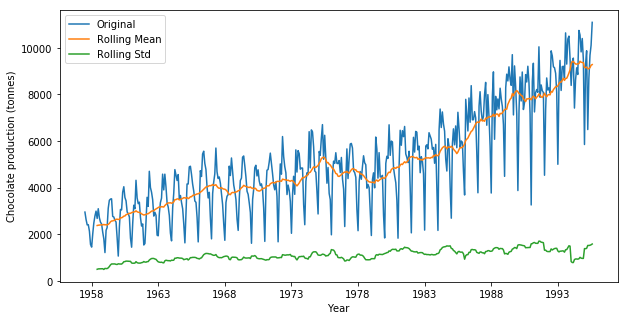

Results of Dickey-Fuller Test:


Test statistic                   0.923529
p_value                          0.993390
Number of lags used             13.000000
Number of observations used    444.000000
critical value (1%)             -3.445164
critical value (10%)            -2.570249
critical value (5%)             -2.868072
dtype: float64

In [8]:
#Checking if the data is stationary or not
def stationarity_test(dataset):
        
    plt.figure(figsize = (10, 5))
    ax = plt.subplot()
    ax.set_xlabel("Year")
    ax.set_ylabel("Chocolate production (tonnes)")
    ax.plot(dataset, label = 'Original')
    ax.plot(pd.rolling_mean(dataset, window=12), label = 'Rolling Mean')
    ax.plot(pd.rolling_std(dataset, window=12), label = 'Rolling Std')
    ax.legend()
    plt.show()
    
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(dataset, autolag = 'AIC')
    dftest_output = pd.Series(dftest[0:4], index = ['Test statistic', 'p_value', 'Number of lags used', 'Number of observations used'])
    for keys, values in dftest[4].items():
        dftest_output['critical value (%s)' %keys] = values 
    return dftest_output

stationarity_test(df[df.columns[0]])

The results of the statsitical test indicates the non-stationary the observations. Hence, the next step is to convert the dataset into a stationary time series. The first strategy to use is to apply "log" function on the observations which partially removes trend in the dataset as the result of the test indicates.

In [11]:
np.log(df[df.columns[0]]).head()

Month
1957-07-01    7.990577
1957-08-01    7.876638
1957-09-01    7.784889
1957-10-01    7.788626
1957-11-01    7.666690
Name: Volume, dtype: float64

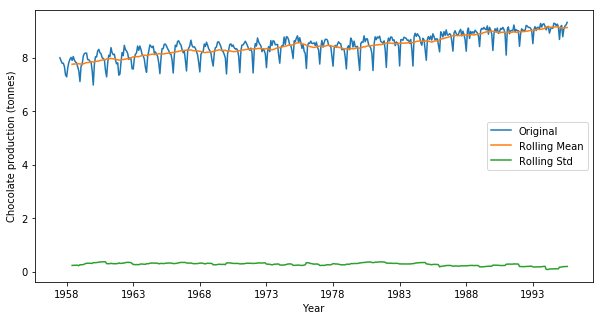

Results of Dickey-Fuller Test:


Test statistic                  -0.629981
p_value                          0.864063
Number of lags used             14.000000
Number of observations used    443.000000
critical value (1%)             -3.445198
critical value (10%)            -2.570257
critical value (5%)             -2.868086
dtype: float64

In [10]:
stationarity_test(np.log(df[df.columns[0]]))

The next strategy to try is "differencing"

In [12]:
#Differencing: taking the differece with a particular time lag
ts_diff = np.log(df[df.columns[0]]) - np.log(df[df.columns[0]]).shift()
ts_diff.head()

Month
1957-07-01         NaN
1957-08-01   -0.113938
1957-09-01   -0.091749
1957-10-01    0.003737
1957-11-01   -0.121936
Name: Volume, dtype: float64

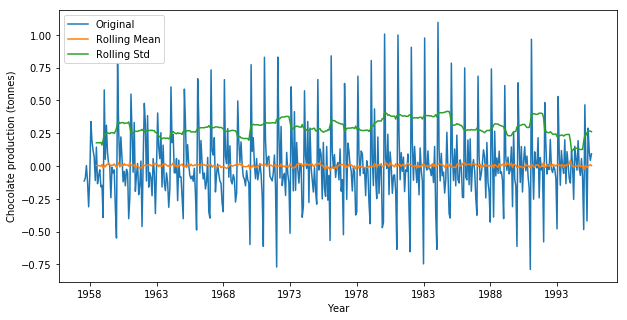

Results of Dickey-Fuller Test:


Test statistic                -8.402331e+00
p_value                        2.214173e-13
Number of lags used            1.300000e+01
Number of observations used    4.430000e+02
critical value (5%)           -2.868086e+00
critical value (10%)          -2.570257e+00
critical value (1%)           -3.445198e+00
dtype: float64

In [49]:
ts_diff.dropna(inplace= True)
stationarity_test(ts_diff)

Log transformation and differencing remove trend in teh dataset and convert it into a stationary one.  

## 3. Predictive model

The dataset is now ready to fit the predictive model which is sasonal auto-regressive integrated moving averages (Seasonal ARIMA). In what follows, a class is defined to implement SARIMA along with a parameter tunning method which takes the advantage of [Pyramid](https://github.com/tgsmith61591/pyramid). 

In [328]:
class myARIMA(object):
    
    """
    Implementing Seasonal Auto-Regressive Integrated Moving Averages (SARIMA) method 
    
    """
    
    def __init__(self, timeseries, model):
        self.timeseries = timeseries
        self.model = model
        
    def cor_(self):
        """
        Constructing autocorrelation and partial autocorrelation plots 
        
        """
        _diff = self.timeseries - self.timeseries.shift()
        _diff.dropna(inplace=True)
        
        fig = plt.figure(figsize=(20,10)) 
        plt.subplot(211)
        plot_acf(_diff, ax=plt.gca())
        plt.title('Autocorrelation function')
        
        plt.subplot(212)
        plot_pacf(_diff, ax=plt.gca())
        plt.title('Partial autocorrelation function')
        
        plt.show()
        
    def auto_fit_(self, init_p, init_q, max_p, max_q, m, init_P, d, D, seasonal, stepwise):
        """
        Tunning the parameters of ARIMA 
        
        """
        
        #Creating train and test sets
        train_size = int(0.8*len(self.timeseries))
        train = self.timeseries[0:train_size]
        
        stepwise_fit = auto_arima(train, start_p=init_p, start_q=init_q, max_p=max_p, max_q=max_q, m=m,
                          start_P=init_P, seasonal=True, d=d, D=D, trace=True,
                          error_action='ignore',  # don't want to know if an order does not work
                          suppress_warnings=True,  # don't want convergence warnings
                          stepwise=stepwise)  # set to stepwise

        return stepwise_fit.summary()
               
    def model_(self, p, d, q, P, D, Q, m):
        """
        Building ARIMA model 
    
        """     
        #Creating train and test sets
        train_size = int(0.8*len(self.timeseries))
        train, test = self.timeseries[0:train_size], self.timeseries[train_size:]
        
        #Training data
        self.model = self.model(train, order=(p, d, q),seasonal_order=(P,D,Q,m))
        model_fit = self.model.fit()
        print(model_fit.summary())
        
        #Prediction
        y_hat = model_fit.predict(start=len(train), end=len(train) + (len(test)-1), typ='levels', dynamic=True) 
        error = sqrt(mean_squared_error(test, y_hat))
        print("Test RMSE: {:5.5f}".format(error))
        
        #Visualization
        self.__plot(np.exp(test), np.exp(y_hat))
        
        #Cross-validation
        self.__cross_validation(self.timeseries, self.model)
        
    def __plot(self, timeseries1, timeseries2):
        
        fig = plt.figure(figsize = (10,5))
        plt.subplot()
        plt.plot(timeseries1, color = 'b')
        plt.plot(timeseries2, color = 'g')
        plt.title('Forecasting plot')
        plt.show()
            
    def __cross_validation(self, timeseries, model):
        """
        Cross-validation 
    
        """         
        kf = TimeSeriesSplit(n_splits=3)
        err = []

        #Filtering train and test data
        for train_index, test_index in kf.split(self.timeseries):
            train_series = self.timeseries[train_index]
            test_series = self.timeseries[test_index]
            print('Number of observations: {}'.format((len(train_series) + len(test_series))))
            print('Training observations: {}'.format(len(train_series)))
            print('Testing observations: {}'.format(len(test_series)))
            cross_mod = self.model.fit(disp = 0)
            cross_pred = cross_mod.predict(start=len(train_series), end=len(train_series) + (len(test_series)-1), typ='levels', dynamic=True) 
            print("RMSE: {:5.5f}".format(sqrt(mean_squared_error(test_series, cross_pred))))
            err.append(sqrt(mean_squared_error(test_series, cross_pred)))
            
        print("Cross-Validation RMSE: {:5.5f}".format(np.mean(err)))     

In [329]:
obj = myARIMA(timeseries = np.log(df[df.columns[0]]), model = SARIMAX)

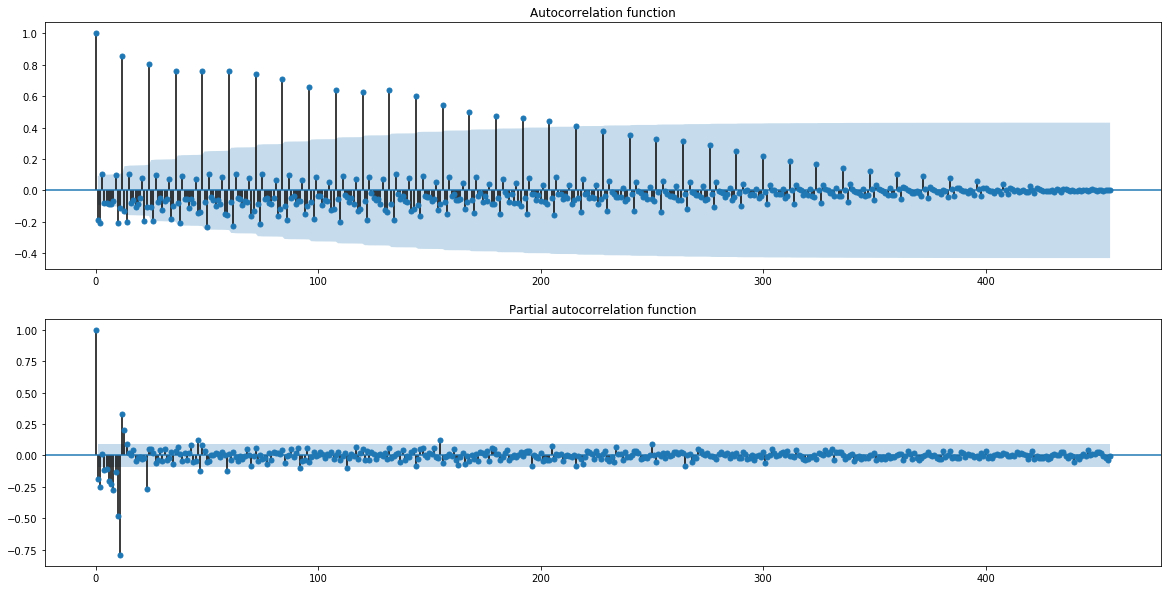

In [320]:
obj.cor_()

The autocorrelation and partial autocorrelation graphs suggest to pick "2" as AR nad MA orders. In order to tune these parameters as well as seasonality ones, a stepwise search is performed using simulated "auto.arima" in Python. 

In [162]:
obj.auto_fit_(1, 1, 3, 3, 12, 0, 1, 1, seasonal = True, stepwise = True)

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=-598.376, BIC=-578.863, Fit time=3.588 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=-488.357, BIC=-472.746, Fit time=0.886 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=-598.355, BIC=-582.744, Fit time=1.351 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=-610.544, BIC=-587.128, Fit time=1.941 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 0, 12); AIC=-541.549, BIC=-522.036, Fit time=1.662 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=-612.412, BIC=-585.094, Fit time=8.314 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=-611.526, BIC=-588.110, Fit time=7.629 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=-612.179, BIC=-580.958, Fit time=8.763 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_orde

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  366
Model:             SARIMAX(3, 1, 3)x(0, 1, 2, 12)   Log Likelihood                 320.751
Date:                            Sat, 14 Apr 2018   AIC                           -621.502
Time:                                    18:01:13   BIC                           -582.476
Sample:                                         0   HQIC                          -605.994
                                            - 366                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   -3.74e-06      0.000     -0.013      0.990      -0.001       0.001
ar.L1         -0.5712      0.146     -3.911      0.000      -0.858      -0.285
ar.L2         -0.4089      0.155     -2.632      0.008      -0.713      -0.104
ar.L3          0.3082      0.063      4.867      0.000       0.184       0.432
ma.L1         -0.1133      0.153     -0.740      0.459      -0.413       0.187
ma.L2         -0.0096      0.145     -0.067      0.947      -0.293       0.274
ma.L3         -0.6481      0.118     -5.480      0.000      -0.880      -0.416
ma.S.L12      -0.5948      0.060     -9.866      0.000      -0.713      -0.477
ma.S.L24      -0.2081      0.053     -3.915      0.000      -0.312      -0.104
sigma2         0.0092      0.001     12.265      0.000       0.008       0.011
===================================================================================
Ljung-Box (Q):                       35.41   Jarque-Bera (JB):                 0.87
Prob(Q):                              0.68   Prob(JB):                         0.65
Heteroskedasticity (H):               1.34   Skew:                            -0.05
Prob(H) (two-sided):                  0.11   Kurtosis:                         2.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The final step is to train the training set and then make forecasting using the test data.

                                 Statespace Model Results                                 
Dep. Variable:                             Volume   No. Observations:                  366
Model:             SARIMAX(3, 1, 3)x(0, 1, 2, 12)   Log Likelihood                 321.824
Date:                            Sun, 15 Apr 2018   AIC                           -625.648
Time:                                    12:04:26   BIC                           -590.525
Sample:                                07-01-1957   HQIC                          -611.691
                                     - 12-01-1987                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7239      0.103     -7.009      0.000      -0.926      -0.521
ar.L2         -0.5709      0.122   

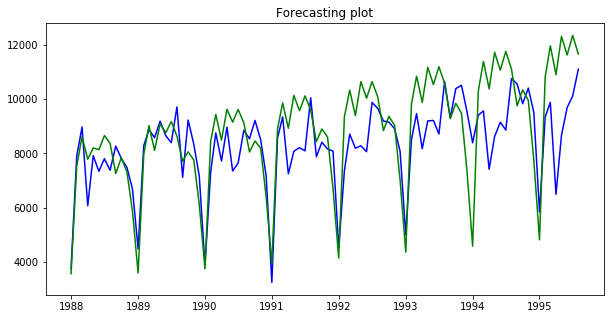

Number of observations: 230
Training observations: 116
Testing observations: 114
RMSE: 0.30579
Number of observations: 344
Training observations: 230
Testing observations: 114
RMSE: 0.13505
Number of observations: 458
Training observations: 344
Testing observations: 114
RMSE: 0.16311
Cross-Validation RMSE: 0.20132


In [330]:
obj.model_(3, 1, 3, 0, 1, 2, 12)

The value of the cross-valdiation "RMSE" measure is quite close to that of train-test validation approach. It can be concluded that the SARIMA model fairly represents the time series dataset. Needless to say, the predictive model can further be improved to provide more accurate prediction. It can be done by further exploration of the dataset. 